In [452]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from scipy import special
from sklearn.metrics import r2_score        
from sklearn.metrics import mean_squared_log_error
import optuna.integration.lightgbm as lgb
from joblib import dump, load
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/trained-models-housing/gp.pkl
/kaggle/input/trained-models-housing/lgbm_w_gp.pkl
/kaggle/input/trained-models-housing/lgbm.pkl
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [453]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-4.15003936, -4.11695608, -3.91764707, ...,  3.16496077,
          3.55997917,  3.58975046])),
 (0.9975191801735868, 1.790570681147346e-15, 0.9955315707916029))

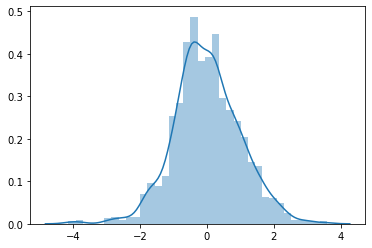

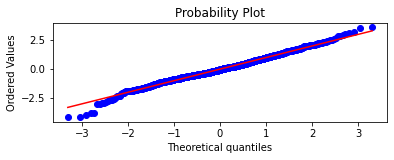

In [454]:
train['SalePrice'], SalePrice_lamb = stats.boxcox(train['SalePrice'])
labels_scaler = preprocessing.StandardScaler().fit(train[['SalePrice']])
labels = labels_scaler.transform(train[['SalePrice']]).reshape(-1)

sns.distplot(labels)
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(labels, dist=stats.norm, plot=ax)

In [455]:
#check that our features are consistent between the Test and Train
train_test_intersection = np.intersect1d(train.columns, test.columns)
print('Similar Features')
print (train_test_intersection)
train_test_difference = np.setdiff1d(train.columns, test.columns)

print('Different Features')
print (train_test_difference)

Similar Features
['1stFlrSF' '2ndFlrSF' '3SsnPorch' 'Alley' 'BedroomAbvGr' 'BldgType'
 'BsmtCond' 'BsmtExposure' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtFinType1'
 'BsmtFinType2' 'BsmtFullBath' 'BsmtHalfBath' 'BsmtQual' 'BsmtUnfSF'
 'CentralAir' 'Condition1' 'Condition2' 'Electrical' 'EnclosedPorch'
 'ExterCond' 'ExterQual' 'Exterior1st' 'Exterior2nd' 'Fence' 'FireplaceQu'
 'Fireplaces' 'Foundation' 'FullBath' 'Functional' 'GarageArea'
 'GarageCars' 'GarageCond' 'GarageFinish' 'GarageQual' 'GarageType'
 'GarageYrBlt' 'GrLivArea' 'HalfBath' 'Heating' 'HeatingQC' 'HouseStyle'
 'Id' 'KitchenAbvGr' 'KitchenQual' 'LandContour' 'LandSlope' 'LotArea'
 'LotConfig' 'LotFrontage' 'LotShape' 'LowQualFinSF' 'MSSubClass'
 'MSZoning' 'MasVnrArea' 'MasVnrType' 'MiscFeature' 'MiscVal' 'MoSold'
 'Neighborhood' 'OpenPorchSF' 'OverallCond' 'OverallQual' 'PavedDrive'
 'PoolArea' 'PoolQC' 'RoofMatl' 'RoofStyle' 'SaleCondition' 'SaleType'
 'ScreenPorch' 'Street' 'TotRmsAbvGrd' 'TotalBsmtSF' 'Utilities'
 'WoodDeckSF'

In [456]:
train_features = pd.DataFrame()
test_features = pd.DataFrame()

In [457]:
# MSSubClass: Identifies the type of dwelling involved in the sale.	

#         20	1-STORY 1946 & NEWER ALL STYLES
#         30	1-STORY 1945 & OLDER
#         40	1-STORY W/FINISHED ATTIC ALL AGES
#         45	1-1/2 STORY - UNFINISHED ALL AGES
#         50	1-1/2 STORY FINISHED ALL AGES
#         60	2-STORY 1946 & NEWER
#         70	2-STORY 1945 & OLDER
#         75	2-1/2 STORY ALL AGES
#         80	SPLIT OR MULTI-LEVEL
#         85	SPLIT FOYER
#         90	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES
column = 'MSSubClass'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [458]:
# MSZoning: Identifies the general zoning classification of the sale.

#        A	Agriculture
#        C (all)	Commercial
#        FV	Floating Village Residential
#        I	Industrial
#        RH	Residential High Density
#        RL	Residential Low Density
#        RP	Residential Low Density Park 
#        RM	Residential Medium Density
column = 'MSZoning'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-3.65142557, -3.41844765, -3.40119259, ...,  5.78858542,
          5.86255887,  6.4317708 ])),
 (0.952240670328636, 2.3675269425926065e-15, 0.9503432807567156))

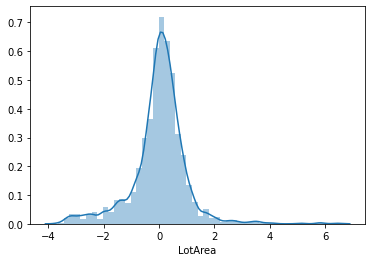

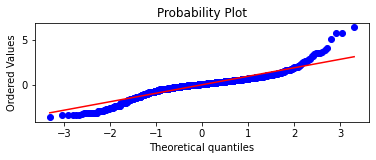

In [459]:
# LotArea: Lot size in square feet
column = 'LotArea'

fillvalue = train[column].mean()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

# box-cox to improve normaility
train[column], lamb = stats.boxcox(train[column])
scaler = preprocessing.StandardScaler().fit(train[[column]])
train[[column]] = scaler.transform(train[[column]])
train_features = pd.concat([train_features,train[column]],axis=1)

test[column] = stats.boxcox(test[column],lamb)
scaler = preprocessing.StandardScaler().fit(test[[column]])
test[[column]] = scaler.transform(test[[column]])
test_features = pd.concat([test_features,test[column]],axis=1)

sns.distplot(train[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

In [460]:
# Street: Type of road access to property

#        Grvl	Gravel	
#        Pave	Paved
column = 'Street'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [461]:
# Alley: Type of alley access to property

#        Grvl	Gravel
#        Pave	Paved
#        NA 	No alley access
column = 'Alley'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [462]:
# LotShape: General shape of property

#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
column = 'LotShape'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [463]:
# LandContour: Flatness of the property

#        Lvl	Near Flat/Level	
#        Bnk	Banked - Quick and significant rise from street grade to building
#        HLS	Hillside - Significant slope from side to side
#        Low	Depression
column = 'LandContour'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [464]:
# Utilities: Type of utilities available
		
#        AllPub	All public Utilities (E,G,W,& S)	
#        NoSewr	Electricity, Gas, and Water (Septic Tank)
#        NoSeWa	Electricity and Gas Only
#        ELO	Electricity only	
column = 'Utilities'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [465]:
# LotConfig: Lot configuration

#        Inside	Inside lot
#        Corner	Corner lot
#        CulDSac	Cul-de-sac
#        FR2	Frontage on 2 sides of property
#        FR3	Frontage on 3 sides of property
column = 'LotConfig'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [466]:
# LandSlope: Slope of property
		
#        Gtl	Gentle slope
#        Mod	Moderate Slope	
#        Sev	Severe Slope
column = 'LandSlope'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [467]:
# Neighborhood: Physical locations within Ames city limits

#        Blmngtn	Bloomington Heights
#        Blueste	Bluestem
#        BrDale	Briardale
#        BrkSide	Brookside
#        ClearCr	Clear Creek
#        CollgCr	College Creek
#        Crawfor	Crawford
#        Edwards	Edwards
#        Gilbert	Gilbert
#        IDOTRR	Iowa DOT and Rail Road
#        MeadowV	Meadow Village
#        Mitchel	Mitchell
#        Names	North Ames
#        NoRidge	Northridge
#        NPkVill	Northpark Villa
#        NridgHt	Northridge Heights
#        NWAmes	Northwest Ames
#        OldTown	Old Town
#        SWISU	South & West of Iowa State University
#        Sawyer	Sawyer
#        SawyerW	Sawyer West
#        Somerst	Somerset
#        StoneBr	Stone Brook
#        Timber	Timberland
#        Veenker	Veenker
column = 'Neighborhood'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [468]:
# Condition1: Proximity to various conditions
	
#        Artery	Adjacent to arterial street
#        Feedr	Adjacent to feeder street	
#        Norm	Normal	
#        RRNn	Within 200' of North-South Railroad
#        RRAn	Adjacent to North-South Railroad
#        PosN	Near positive off-site feature--park, greenbelt, etc.
#        PosA	Adjacent to postive off-site feature
#        RRNe	Within 200' of East-West Railroad
#        RRAe	Adjacent to East-West Railroad
column = 'Condition1'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [469]:
# Condition2: Proximity to various conditions (if more than one is present)
		
#        Artery	Adjacent to arterial street
#        Feedr	Adjacent to feeder street	
#        Norm	Normal	
#        RRNn	Within 200' of North-South Railroad
#        RRAn	Adjacent to North-South Railroad
#        PosN	Near positive off-site feature--park, greenbelt, etc.
#        PosA	Adjacent to postive off-site feature
#        RRNe	Within 200' of East-West Railroad
#        RRAe	Adjacent to East-West Railroad
column = 'Condition2'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [470]:
# BldgType: Type of dwelling
		
#        1Fam	Single-family Detached	
#        2FmCon	Two-family Conversion; originally built as one-family dwelling
#        Duplx	Duplex
#        TwnhsE	Townhouse End Unit
#        TwnhsI	Townhouse Inside Unit
column = 'BldgType'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [471]:
# HouseStyle: Style of dwelling
	
#        1Story	One story
#        1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished
#        SFoyer	Split Foyer
#        SLvl	Split Level
column = 'HouseStyle'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [472]:
# OverallQual: Rates the overall material and finish of the house

#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average
#        5	Average
#        4	Below Average
#        3	Fair
#        2	Poor
#        1	Very Poor
column = 'OverallQual'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [473]:
# OverallCond: Rates the overall condition of the house

#        10	Very Excellent
#        9	Excellent
#        8	Very Good
#        7	Good
#        6	Above Average	
#        5	Average
#        4	Below Average	
#        3	Fair
#        2	Poor
#        1	Very Poor
column = 'OverallCond'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [474]:
# RoofStyle: Type of roof

#        Flat	Flat
#        Gable	Gable
#        Gambrel	Gabrel (Barn)
#        Hip	Hip
#        Mansard	Mansard
#        Shed	Shed
column = 'RoofStyle'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [475]:
# RoofMatl: Roof material

#        ClyTile	Clay or Tile
#        CompShg	Standard (Composite) Shingle
#        Membran	Membrane
#        Metal	Metal
#        Roll	Roll
#        Tar&Grv	Gravel & Tar
#        WdShake	Wood Shakes
#        WdShngl	Wood Shingles
column = 'RoofMatl'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [476]:
# Exterior1st: Exterior covering on house

#        AsbShng	Asbestos Shingles
#        AsphShn	Asphalt Shingles
#        BrkComm	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        CemntBd	Cement Board
#        HdBoard	Hard Board
#        ImStucc	Imitation Stucco
#        MetalSd	Metal Siding
#        Other	Other
#        Plywood	Plywood
#        PreCast	PreCast	
#        Stone	Stone
#        Stucco	Stucco
#        VinylSd	Vinyl Siding
#        Wd Sdng	Wood Siding
#        WdShing	Wood Shingles
column = 'Exterior1st'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [477]:
# Exterior2nd: Exterior covering on house (if more than one material)

#        AsbShng	Asbestos Shingles
#        AsphShn	Asphalt Shingles
#        BrkComm	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        CemntBd	Cement Board
#        HdBoard	Hard Board
#        ImStucc	Imitation Stucco
#        MetalSd	Metal Siding
#        Other	Other
#        Plywood	Plywood
#        PreCast	PreCast
#        Stone	Stone
#        Stucco	Stucco
#        VinylSd	Vinyl Siding
#        Wd Sdng	Wood Siding
#        WdShing	Wood Shingles
column = 'Exterior2nd'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [478]:
# MasVnrType: Masonry veneer type

#        BrkCmn	Brick Common
#        BrkFace	Brick Face
#        CBlock	Cinder Block
#        None	None
#        Stone	Stone
column = 'MasVnrType'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [479]:
# ExterQual: Evaluates the quality of the material on the exterior 
		
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
column = 'ExterQual'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [480]:
# ExterCond: Evaluates the present condition of the material on the exterior
		
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
column = 'ExterCond'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [481]:
# Foundation: Type of foundation
		
#        BrkTil	Brick & Tile
#        CBlock	Cinder Block
#        PConc	Poured Contrete	
#        Slab	Slab
#        Stone	Stone
#        Wood	Wood
column = 'Foundation'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [482]:
# BsmtQual: Evaluates the height of the basement

#        Ex	Excellent (100+ inches)	
#        Gd	Good (90-99 inches)
#        TA	Typical (80-89 inches)
#        Fa	Fair (70-79 inches)
#        Po	Poor (<70 inches
#        NA	No Basement
column = 'BsmtQual'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [483]:
# BsmtCond: Evaluates the general condition of the basement

#        Ex	Excellent
#        Gd	Good
#        TA	Typical - slight dampness allowed
#        Fa	Fair - dampness or some cracking or settling
#        Po	Poor - Severe cracking, settling, or wetness
#        NA	No Basement
column = 'BsmtCond'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [484]:
# BsmtExposure: Refers to walkout or garden level walls

#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement
column = 'BsmtExposure'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [485]:
# BsmtFinType1: Rating of basement finished area

#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement
column = 'BsmtFinType1'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [486]:
# BsmtFinType2: Rating of basement finished area (if multiple types)

#        GLQ	Good Living Quarters
#        ALQ	Average Living Quarters
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        LwQ	Low Quality
#        Unf	Unfinshed
#        NA	No Basement
column = 'BsmtFinType2'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-2.41116693, -2.41116693, -2.41116693, ...,  4.88552238,
          4.89920368, 11.52094923])),
 (0.9583630454940708, 4.607218348968633e-16, 0.9564534567679275))

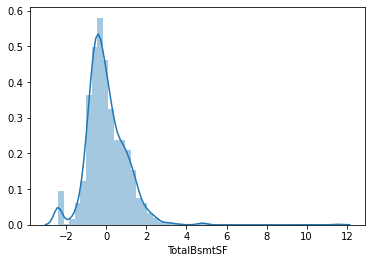

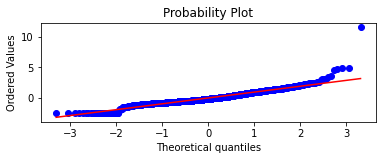

In [487]:
# TotalBsmtSF: Total square feet of basement area
column = 'TotalBsmtSF'

fillvalue = 0.0
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)


scaler = preprocessing.StandardScaler().fit(train[[column]])
train[[column]] = scaler.transform(train[[column]])
train_features = pd.concat([train_features,train[column]],axis=1)


scaler = preprocessing.StandardScaler().fit(test[[column]])
test[[column]] = scaler.transform(test[[column]])
test_features = pd.concat([test_features,test[column]],axis=1)

sns.distplot(train[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

In [488]:
# Heating: Type of heating
		
#        Floor	Floor Furnace
#        GasA	Gas forced warm air furnace
#        GasW	Gas hot water or steam heat
#        Grav	Gravity furnace	
#        OthW	Hot water or steam heat other than gas
#        Wall	Wall furnace
column = 'Heating'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [489]:
# HeatingQC: Heating quality and condition

#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
column = 'HeatingQC'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [490]:
# CentralAir: Central air conditioning

#        N	No
#        Y	Yes
column = 'CentralAir'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [491]:
# Electrical: Electrical system

#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed
column = 'Electrical'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-3.93939706, -3.56799025, -3.0110159 , ...,  3.16892534,
          3.25086965,  4.31766381])),
 (0.9997831514633274, 1.8687909586780734e-15, 0.9977910309995867))

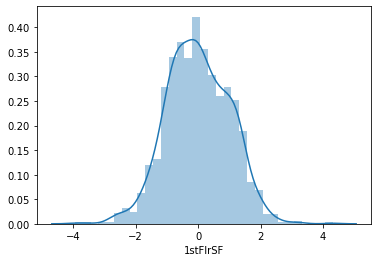

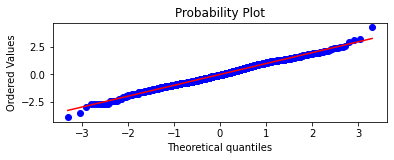

In [492]:
# 1stFlrSF: First Floor square feet
column = '1stFlrSF'

fillvalue = train[column].mean()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

# box-cox to improve normaility
train[column], lamb = stats.boxcox(train[column])
scaler = preprocessing.StandardScaler().fit(train[[column]])
train[[column]] = scaler.transform(train[[column]])
train_features = pd.concat([train_features,train[column]],axis=1)

test[column] = stats.boxcox(test[column],lamb)
scaler = preprocessing.StandardScaler().fit(test[[column]])
test[[column]] = scaler.transform(test[[column]])
test_features = pd.concat([test_features,test[column]],axis=1)

sns.distplot(train[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

In [493]:
# 2ndFlrSF: Second floor square feet
column = '2ndFlrSF'

fillvalue = 0
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

train.loc[train[column]>0,column] = 1
train_features = pd.concat([train_features,train[column]],axis=1)

test.loc[test[column]>0,column] = 1
test_features = pd.concat([test_features,test[column]],axis=1)



((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-4.34962069, -3.54337815, -3.27072663, ...,  3.42632836,
          3.55839095,  4.12615647])),
 (0.999727809715066, -1.0901901486357053e-15, 0.9977357995226666))

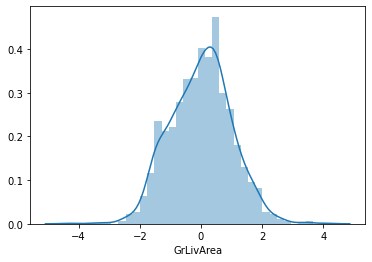

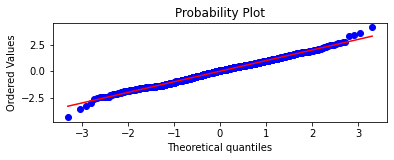

In [494]:
# GrLivArea: Above grade (ground) living area square feet
column = 'GrLivArea'

fillvalue = train[column].mean()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

# box-cox to improve normaility
train[column], lamb = stats.boxcox(train[column])
scaler = preprocessing.StandardScaler().fit(train[[column]])
train[[column]] = scaler.transform(train[[column]])
train_features = pd.concat([train_features,train[column]],axis=1)

test[column] = stats.boxcox(test[column],lamb)
scaler = preprocessing.StandardScaler().fit(test[[column]])
test[[column]] = scaler.transform(test[[column]])
test_features = pd.concat([test_features,test[column]],axis=1)

sns.distplot(train[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

In [495]:
# BsmtFullBath: Basement full bathrooms
column = 'BsmtFullBath'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [496]:
# BsmtHalfBath: Basement half bathrooms
column = 'BsmtHalfBath'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [497]:
# FullBath: Full bathrooms above grade
column = 'FullBath'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [498]:
# HalfBath: Half baths above grade
column = 'HalfBath'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [499]:
#Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
column = 'BedroomAbvGr'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [500]:
# Kitchen: Kitchens above grade
column = 'KitchenAbvGr'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [501]:
# KitchenQual: Kitchen quality

#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
column = 'KitchenQual'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [502]:
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
column = 'TotRmsAbvGrd'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [503]:
# Functional: Home functionality (Assume typical unless deductions are warranted)

#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only
column = 'Functional'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [504]:
# Fireplaces: Number of fireplaces
column = 'Fireplaces'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [505]:
# FireplaceQu: Fireplace quality

#        Ex	Excellent - Exceptional Masonry Fireplace
#        Gd	Good - Masonry Fireplace in main level
#        TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#        Fa	Fair - Prefabricated Fireplace in basement
#        Po	Poor - Ben Franklin Stove
#        NA	No Fireplace
column = 'FireplaceQu'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [506]:
# GarageType: Garage location
		
#        2Types	More than one type of garage
#        Attchd	Attached to home
#        Basment	Basement Garage
#        BuiltIn	Built-In (Garage part of house - typically has room above garage)
#        CarPort	Car Port
#        Detchd	Detached from home
#        NA	No Garage
column = 'GarageType'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [507]:
# GarageFinish: Interior finish of the garage

#        Fin	Finished
#        RFn	Rough Finished	
#        Unf	Unfinished
#        NA	No Garage
column = 'GarageFinish'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [508]:
# GarageCars: Size of garage in car capacity
column = 'GarageCars'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([-2.21296298, -2.21296298, -2.21296298, ...,  4.13144256,
          4.29052058,  4.421526  ])),
 (0.989558227932282, 7.624154358112226e-17, 0.9875864811659539))

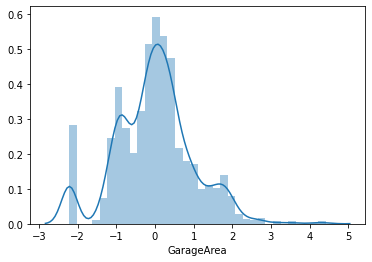

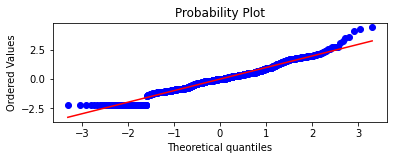

In [509]:
# GarageArea: Size of garage in square feet
column = 'GarageArea'

fillvalue = 0
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

# box-cox to improve normaility
# train[column], lamb = stats.boxcox(train[column])
scaler = preprocessing.StandardScaler().fit(train[[column]])
train[[column]] = scaler.transform(train[[column]])
train_features = pd.concat([train_features,train[column]],axis=1)

# test[column] = stats.boxcox(test[column],lamb)
scaler = preprocessing.StandardScaler().fit(test[[column]])
test[[column]] = scaler.transform(test[[column]])
test_features = pd.concat([test_features,test[column]],axis=1)

sns.distplot(train[column])
fig = plt.figure()
ax = fig.add_subplot(212)
stats.probplot(train[column], dist=stats.norm, plot=ax)

In [510]:
# GarageQual: Garage quality

#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage
column = 'GarageQual'

fillvalue = 'NA'
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [511]:
# GarageCond: Garage condition

#        Ex	Excellent
#        Gd	Good
#        TA	Typical/Average
#        Fa	Fair
#        Po	Poor
#        NA	No Garage
column = 'GarageCond'

fillvalue = 'NA'
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [512]:
# PavedDrive: Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
column = 'PavedDrive'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [513]:
# WoodDeckSF: Wood deck area in square feet
column = 'WoodDeckSF'

fillvalue = 0
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

train.loc[train[column]>0,column] = 1
train_features = pd.concat([train_features,train[column]],axis=1)

test.loc[test[column]>0,column] = 1
test_features = pd.concat([test_features,test[column]],axis=1)

In [514]:
# OpenPorchSF: Open porch area in square feet
column = 'OpenPorchSF'

fillvalue = 0
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

train.loc[train[column]>0,column] = 1
train_features = pd.concat([train_features,train[column]],axis=1)

test.loc[test[column]>0,column] = 1
test_features = pd.concat([test_features,test[column]],axis=1)

In [515]:
# EnclosedPorch: Enclosed porch area in square feet
column = 'EnclosedPorch'

fillvalue = 0
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

train.loc[train[column]>0,column] = 1
train_features = pd.concat([train_features,train[column]],axis=1)

test.loc[test[column]>0,column] = 1
test_features = pd.concat([test_features,test[column]],axis=1)

In [516]:
# 3SsnPorch: Three season porch area in square feet
column = '3SsnPorch'

fillvalue = 0
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

train.loc[train[column]>0,column] = 1
train_features = pd.concat([train_features,train[column]],axis=1)

test.loc[test[column]>0,column] = 1
test_features = pd.concat([test_features,test[column]],axis=1)

In [517]:
# ScreenPorch: Screen porch area in square feet
column = 'ScreenPorch'

fillvalue = 0
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)

train.loc[train[column]>0,column] = 1
train_features = pd.concat([train_features,train[column]],axis=1)

test.loc[test[column]>0,column] = 1
test_features = pd.concat([test_features,test[column]],axis=1)

In [518]:
# # PoolQC: Pool quality
		
# #        Ex	Excellent
# #        Gd	Good
# #        TA	Average/Typical
# #        Fa	Fair
# #        NA	No Pool
column = 'PoolQC'

fillvalue = 'NA'
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [519]:
# Fence: Fence quality
		
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence
column = 'Fence'

fillvalue = 'NA'
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [520]:
# MiscFeature: Miscellaneous feature not covered in other categories
		
#        Elev	Elevator
#        Gar2	2nd Garage (if not described in garage section)
#        Othr	Other
#        Shed	Shed (over 100 SF)
#        TenC	Tennis Court
#        NA	None
column = 'MiscFeature'

fillvalue = 'NA'
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [521]:
# # SaleType: Type of sale
		
#        WD 	Warranty Deed - Conventional
#        CWD	Warranty Deed - Cash
#        VWD	Warranty Deed - VA Loan
#        New	Home just constructed and sold
#        COD	Court Officer Deed/Estate
#        Con	Contract 15% Down payment regular terms
#        ConLw	Contract Low Down payment and low interest
#        ConLI	Contract Low Interest
#        ConLD	Contract Low Down
#        Oth	Other
column = 'SaleType'

fillvalue = train[column].mode()
train[column] = train[column].fillna(fillvalue)
test[column] = test[column].fillna(fillvalue)
        
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
train_features = pd.concat([train_features ,dummies],axis=1)
dummies = pd.get_dummies(train[column], columns=[column],prefix = column)
test_features = pd.concat([test_features,dummies],axis=1)

In [522]:
X, X_val, Y, Y_val = train_test_split(train_features, labels, test_size=0.2, random_state=42)

# dtrain = lgb.Dataset(X, label=Y)
# dval = lgb.Dataset(X_val, label=Y_val)
# params = { "objective": "regression",
#           "metric": "l2",
#           "boosting_type": "dart",
#           "early_stopping_round": 100,
#           "num_iterations": 1000,
#           "n_jobs": 4}

# model = lgb.train( params, dtrain, valid_sets=[dval],verbose_eval=-1)
model = load('../input/trained-models-housing/lgbm.pkl')

In [523]:
# dump(model,'lgbm.pkl')
prediction = model.predict(X_val)
prediction = labels_scaler.inverse_transform(prediction)
prediction = special.inv_boxcox(prediction, SalePrice_lamb) 
SalesPrice = labels_scaler.inverse_transform(Y_val)
SalesPrice = special.inv_boxcox(SalesPrice, SalePrice_lamb) 
print('r2',r2_score(prediction,SalesPrice))
print('msle',mean_squared_log_error(prediction,SalesPrice))

r2 0.8814200447797953
msle 0.02008689435758249


In [524]:
# from gplearn.genetic import SymbolicTransformer
# function_set = ['add', 'sub', 'mul', 'div',
#                 'sqrt', 'log', 'abs', 'neg', 'inv',
#                 'max', 'min']
# gp = SymbolicTransformer(generations=1000, population_size=2000,
#                          hall_of_fame=100, n_components=100,
#                          function_set=function_set,
#                          parsimony_coefficient=0.0005,
#                          max_samples=0.9, verbose=1,
#                          random_state=0, n_jobs=4)
# gp.fit(train_features, labels)
gp = load('../input/trained-models-housing/gp.pkl')

In [525]:
# dump(gp,'gp.pkl')

In [526]:
gp_features = gp.transform(train_features)
new_train_features = np.hstack((train_features, gp_features))
X, X_val, Y, Y_val = train_test_split(new_train_features, labels, test_size=0.2, random_state=42)

# dtrain = lgb.Dataset(X, label=Y)
# dval = lgb.Dataset(X_val, label=Y_val)
# params = { "objective": "regression",
#           "metric": "l2",
#           "boosting_type": "dart",
#           "early_stopping_round": 100,
#           "num_iterations": 1000,
#           "n_jobs": 4}

# model = lgb.train( params, dtrain, valid_sets=[dval],verbose_eval=-1)
model = load('../input/trained-models-housing/lgbm_w_gp.pkl')

In [527]:
# dump(model,'lgbm_w_gp.pkl')
prediction = model.predict(X_val)
prediction = labels_scaler.inverse_transform(prediction)
prediction = special.inv_boxcox(prediction, SalePrice_lamb) 
SalesPrice = labels_scaler.inverse_transform(Y_val)
SalesPrice = special.inv_boxcox(SalesPrice, SalePrice_lamb) 
print('r2',r2_score(prediction,SalesPrice))
print('msle',mean_squared_log_error(prediction,SalesPrice))

r2 0.8706400803976185
msle 0.020686771513684463


In [529]:
# gp_features = gp.transform(test_features)
# new_test_features = np.hstack((test_features, gp_features))
# prediction = model.predict(new_test_features)
# prediction = labels_scaler.inverse_transform(prediction)
# prediction = special.inv_boxcox(prediction, SalePrice_lamb) 
# submission = pd.DataFrame({
#         "Id": test["Id"],
#         "SalePrice": prediction
#     })

# submission.to_csv('submission.csv', index=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').